### **Utkarsh Maheshwari<br>RA1711003011362 ,SRM Institue of Science and Technology**<br>
[Github](https://github.com/utkarsh-mhw)<br>
[Linkedin](www.linkedin.com/in/utkarshmah)<br>
un7993@srmist.edu.in


### **Import VGG19 model**

In [ ]:
# original papere on Neural Style Transfer used the same model
from tensorflow.python.keras.applications.vgg19 import VGG19

[VGG19](https://www.mathworks.com/help/deeplearning/ref/vgg19.html)

In [ ]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)
# include top = false -> Because we dont need to include top layer we only need intermediate layers
# weights = 'imagenet -> Beacuse we want our model to have weights trained on imagenet dataset

model.trainable = False
# we dont want this algorithm to update its parameters we just need its outputs which can be used to extract features of style and content image

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### **Importing libraries and helper functions**

In [ ]:
# to feed the image we need our image in form of tensors and processes in certain way
from tensorflow.python.keras.preprocessing.image import load_img , img_to_array

# preprocess_input will convert our image array into a format our model expects
from tensorflow.python.keras.applications.vgg19 import preprocess_input

# we will instantiate styel and content mdoels based on VGG19 model
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### **image preprocessign and display**

In [ ]:
def load_and_process_image(image_path):
    img = load_img(image_path)  #load the image
    img = img_to_array(img)   #convert image to array
    img = preprocess_input(img)  #convert img array according to VGG19 model
    img = np.expand_dims(img , axis = 0) # our model expects 4 dimension tensor
    return img

In [ ]:
# In order to convert the generated image which will be in above format to human understanble form
def deprocess(x):
#     x is a array
    x[:,:, 0] += 103.939  #since we do not have a deprocessing helper function we will have to do it manually
    x[:,:,1] += 116.779 #these numbers are just reverse of what above preprocess_input heper function does
    x[:,:,2] += 123.68
    x = x[:,:,::-1]
    
    x= np.clip(x,0,255).astype('uint8') #we expanded the image in load_and_process_image so in order to display it we will clip it
    return x


# above function does deprocessing ,below will display image
def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image ,axis = 0) #we expanded image above we need to do opposite now
    
    img = deprocess(img)

    # display the image
    plt.figure(figsize = (10,10))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)


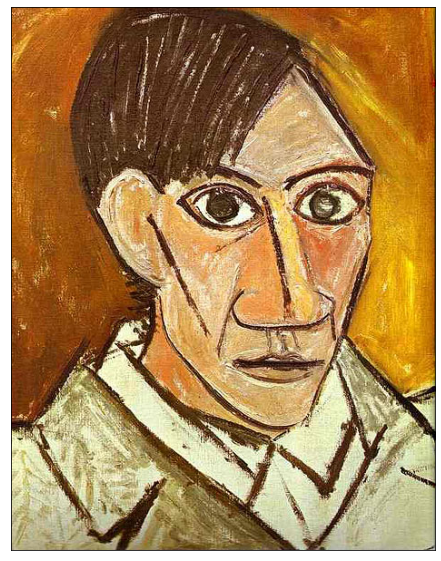

In [ ]:
# testing display_image fuction to display style image
display_image(load_and_process_image('style.jpg'))

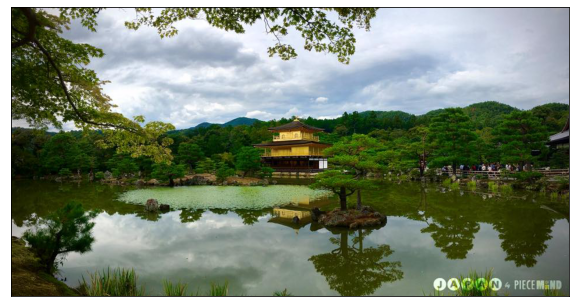

In [ ]:
# testing display_image fuction to display content image
display_image(load_and_process_image('content.jpg'))

### **content ans style models**

We do not want outputs of VGG19 model which classsifies images into 1000 
object categories . We need the activations of intermediate layers by which the feature of image are recognised.
These activations can be used to extarct features from style and content images.


In [ ]:
# block5_conv2 layer can be used to extract features for content image
content_layer = 'block5_conv2' 

# Below mentioned 3 layers wil be used to extract feature for style image
# We can increse/decrease the amount of layers requied for style_layers based on how much detailed features we want
style_layers = [
    'block1_conv1' ,
    'block3_conv1' ,
    'block5_conv1'
]


# now we need to get activations from intermediate layers 
# we create a model with those intermediate layers as output and vgg19 input layer as input
content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

# style model will have input same as VGG19 but weighted output from 3 layers
# for this case I decided to have equal weighthage for all 3 layers
style_models = [Model(inputs = model.input,
                     outputs = model.get_layer(layer).output) for layer in style_layers]


In [ ]:
content_model.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0  

In [ ]:
for style_model in style_models:
  print(style_model.summary())

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________
None
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________

### **content cost**

In order to compute content cost we will find the output of content_model with content image as input and the style image as input . Mean squared error between 2 will give us content_cost

In [ ]:
def content_cost(content, generated):
    a_C = content_model(content)   #cost for content image
    a_G = content_model(generated)  #cost for generated image
    cost = tf.reduce_mean(tf.square(a_C - a_G))  #MSE between the two
    return cost

### **gram matrix**

Gram Matrix was used in [original paper](https://arxiv.org/abs/1508.06576).
Gram matrix gives us strong metric to match feature distribution rather than locating the presence of each specific feature

In [ ]:
# A is numpy array
def gram_matrix(A):
    n_C = int(A.shape[-1]) #this will give us number of channels
    a = tf.reshape(A, [-1, n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a = True)
    return G / tf.cast(n, tf.float32)

### **style cost**

In order to compute style cost we will find the output of style_model with style image as input and the style image as input . Mean squared error between 2 will give us style_cost

In [ ]:
lam = 1. / len(style_models) #since weight for each layer is same

def style_cost(style ,generated):
    J_style = 0
    
    for style_model in style_models:  #style cost for each ouput layer
        a_S = style_model(style)  #cost for style image
        a_G = style_model(generated)  #cost for generated image
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))  #MSE
        J_style += current_cost * lam  #summing up cost for each style model
        
    return J_style #final style_cost

### **training loop**

For each trining loop 4 things are done:


> Find the total cost (style_cost * alpha + content_cost * beta)


> Calculate gradient of cost with respect to generated image using gradient tape


> Update gradient


> Store image associated with lowest cost
























In [ ]:
import time #to find time elapsed for each iteration

generated_images = [] # this list will hold images generated after each iterataion


# alpha and beta are float values
# alpha and beta are the weights we are going to use to find total cost
# alpha and beta are going to what weightage we want to give to style and content cost

def training_loop(content_path, style_path, iterations = 20,
                  alpha = 10., beta = 20.):
  
    content = load_and_process_image(content_path) #load content image
    style = load_and_process_image(style_path)   #load style image
    

    generated = tf.Variable(content)  #initialze generated image with content image as opposed to random image as it will reach to optimum faster

    
    opt =  tf.optimizers.Adam(learning_rate = 7.) #using adam optimizer with learning rate of 7
    
    # we will store best_cost and compare it atfer each iteration so that if during the iterations costs start to rise we can access the lowest cost image
    best_cost = 1e12 + 0.1 #initialized with a very high value
    best_image = None
    
    start_time = time.time()  #to find elepased time for every iteration
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content , generated)  #calculate content cost
            J_style = style_cost(style , generated)   #calculate style cost
            J_total = alpha * J_content + beta * J_style  #calculate total cost
            
        grads = tape.gradient(J_total, generated)   #optimization 
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:  #to store image with least cost
            best_cost = J_total
            best_image = generated.numpy() #because current image is tensor we are going to look at numpy value of array
        
        print('Cost at {}: {}. Time elepsed: {}'.format(i, J_total, time.time() - start_time))
        generated_images.append(generated.numpy())
        
    return best_image
    
    
    

    


In [ ]:
best_image = training_loop('content.jpg' ,'style.jpg')

Cost at 0: 3362283776.0. Time elepsed: 1.173504114151001
Cost at 1: 1894046080.0. Time elepsed: 2.299337148666382
Cost at 2: 1286915968.0. Time elepsed: 3.4262046813964844
Cost at 3: 1022309184.0. Time elepsed: 4.5563788414001465
Cost at 4: 811536768.0. Time elepsed: 5.689035177230835
Cost at 5: 670655744.0. Time elepsed: 6.822685956954956
Cost at 6: 572795648.0. Time elepsed: 7.957520961761475
Cost at 7: 494893600.0. Time elepsed: 9.090965747833252
Cost at 8: 425406752.0. Time elepsed: 10.226939916610718
Cost at 9: 367136416.0. Time elepsed: 11.365057229995728
Cost at 10: 320912224.0. Time elepsed: 12.503530502319336
Cost at 11: 283124736.0. Time elepsed: 13.643945217132568
Cost at 12: 250884784.0. Time elepsed: 14.784311771392822
Cost at 13: 223198784.0. Time elepsed: 15.926642894744873
Cost at 14: 199980528.0. Time elepsed: 17.07222270965576
Cost at 15: 180744976.0. Time elepsed: 18.217727184295654
Cost at 16: 163991488.0. Time elepsed: 19.36402440071106
Cost at 17: 148887808.0. Tim

### **display stylised image**

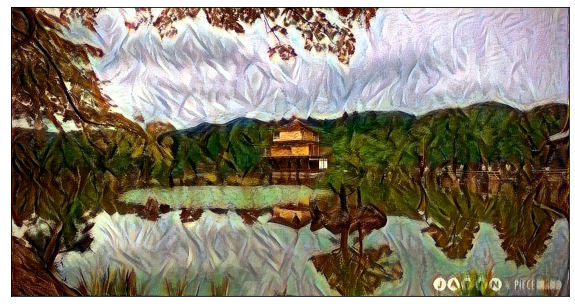

In [ ]:
# generated image
display_image(best_image)

References:<br>
[A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576)<br>[Neural Style Transfer with Eager Execution](https://colab.research.google.com/github/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb)<br>
[Data Camp](https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow)<br>[vgg19](https://www.mathworks.com/help/deeplearning/ref/vgg19.html)